(200, 200, 3)


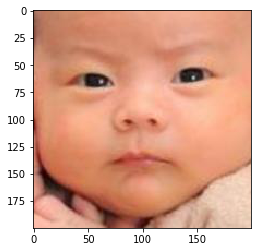

In [12]:
import imageio
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

im = imageio.imread('face_age/001/1000.png')
print(im.shape)

plt.imshow(im, interpolation='nearest')
plt.show()

In [51]:
from sklearn.model_selection import train_test_split

data_dir = "face_age"

batch_size = 32
img_height = 200
img_width = 200


train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

rest_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

rest_ds_X = np.concatenate([x for x, y in rest_ds], axis=0)
rest_ds_y = np.concatenate([y for x, y in rest_ds], axis=0)

X_val, X_test, y_val, y_test = train_test_split(rest_ds_X, rest_ds_y, test_size=0.5, random_state=42)
print(rest_ds_y)

Found 9778 files belonging to 12 classes.
Using 7823 files for training.
Found 9778 files belonging to 12 classes.
Using 1955 files for validation.
[ 7 11 10 ...  6  4  2]


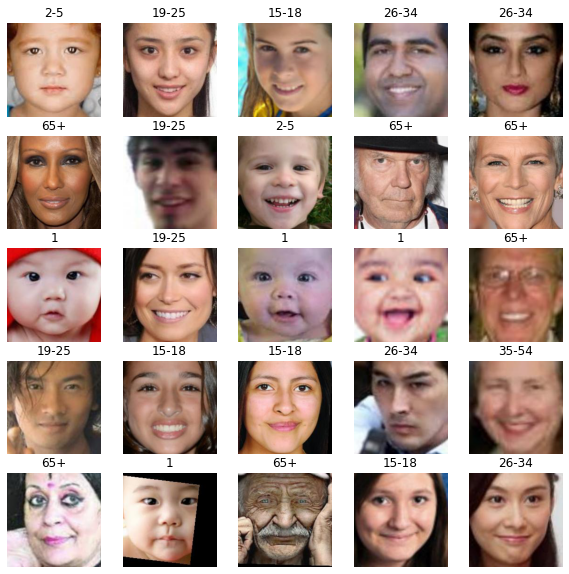

In [44]:
# Shows 25 random images from the training dataset
def display_data():
    class_names = train_ds.class_names
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(25):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            
display_data()

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

# keeps images in memory after they are loaded in the first epoch.
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [36]:
normalization_layer = layers.Rescaling(1. / 255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

0.0 0.97647065


In [37]:
train_ds

<PrefetchDataset shapes: ((None, 200, 200, 3), (None,)), types: (tf.float32, tf.int32)>

In [41]:
for images, labels in train_ds:
    print(images, labels)

tf.Tensor(
[[[[ 85.  61.  51.]
   [ 75.  51.  41.]
   [ 64.  41.  33.]
   ...
   [ 66.  38.  35.]
   [ 68.  40.  37.]
   [ 70.  42.  39.]]

  [[ 81.  57.  47.]
   [ 72.  47.  40.]
   [ 62.  39.  31.]
   ...
   [ 65.  37.  34.]
   [ 67.  39.  36.]
   [ 69.  41.  38.]]

  [[ 76.  52.  42.]
   [ 67.  44.  36.]
   [ 57.  37.  30.]
   ...
   [ 65.  37.  34.]
   [ 67.  39.  36.]
   [ 69.  41.  38.]]

  ...

  [[ 41.  26.  33.]
   [ 44.  29.  36.]
   [ 46.  31.  38.]
   ...
   [ 62.  31.  36.]
   [ 64.  33.  38.]
   [ 63.  32.  37.]]

  [[ 43.  28.  35.]
   [ 43.  28.  35.]
   [ 42.  27.  34.]
   ...
   [ 62.  31.  36.]
   [ 64.  33.  38.]
   [ 64.  33.  38.]]

  [[ 45.  30.  37.]
   [ 41.  26.  33.]
   [ 38.  23.  30.]
   ...
   [ 62.  31.  36.]
   [ 64.  33.  38.]
   [ 64.  33.  38.]]]


 [[[  1.   0.   0.]
   [  1.   0.   0.]
   [  1.   0.   2.]
   ...
   [  0.   0.   0.]
   [  0.   0.   0.]
   [  0.   0.   0.]]

  [[  1.   0.   0.]
   [  1.   0.   2.]
   [  1.   0.   2.]
   ...
   [  0.  

   [111.  74.  58.]]]], shape=(32, 200, 200, 3), dtype=float32) tf.Tensor(
[58 38 25 43 17 41 74  7 12  9 66 11  1 21 55 29 10 40  0 15 57 69 49 23
 11 38 37  0  0 28 17 44], shape=(32,), dtype=int32)
tf.Tensor(
[[[[150. 121. 107.]
   [150. 121. 107.]
   [149. 120. 106.]
   ...
   [102.  80.  67.]
   [ 63.  41.  30.]
   [ 45.  25.  14.]]

  [[150. 121. 107.]
   [149. 120. 106.]
   [149. 120. 106.]
   ...
   [100.  78.  65.]
   [ 62.  40.  29.]
   [ 44.  24.  13.]]

  [[150. 121. 107.]
   [149. 120. 106.]
   [149. 120. 106.]
   ...
   [ 98.  76.  63.]
   [ 60.  38.  27.]
   [ 43.  23.  12.]]

  ...

  [[181. 201. 212.]
   [183. 203. 214.]
   [187. 206. 220.]
   ...
   [196. 164. 149.]
   [197. 164. 149.]
   [196. 163. 148.]]

  [[185. 205. 216.]
   [188. 208. 219.]
   [193. 212. 226.]
   ...
   [196. 164. 149.]
   [196. 163. 148.]
   [196. 163. 148.]]

  [[200. 218. 230.]
   [202. 220. 232.]
   [207. 225. 239.]
   ...
   [196. 164. 149.]
   [196. 163. 148.]
   [196. 163. 148.]]]


 [[[2

   [222. 221. 217.]]]], shape=(32, 200, 200, 3), dtype=float32) tf.Tensor(
[45 18 69  0  3 13  0 40 57  1 60 74 44 25 28 53 48  7 47 31 41  0 15 21
  8  0 14  5 53 52  0 57], shape=(32,), dtype=int32)
tf.Tensor(
[[[[214. 219. 165.]
   [214. 219. 165.]
   [214. 219. 165.]
   ...
   [110.  82.  34.]
   [110.  82.  35.]
   [110.  82.  35.]]

  [[214. 219. 165.]
   [214. 219. 165.]
   [214. 219. 165.]
   ...
   [108.  80.  32.]
   [109.  81.  34.]
   [109.  81.  34.]]

  [[214. 219. 165.]
   [214. 219. 165.]
   [214. 219. 165.]
   ...
   [105.  78.  31.]
   [105.  78.  31.]
   [106.  79.  32.]]

  ...

  [[146. 156. 106.]
   [139. 149.  99.]
   [128. 137.  90.]
   ...
   [ 20.  23.  14.]
   [ 20.  23.  14.]
   [ 20.  23.  14.]]

  [[138. 150. 100.]
   [132. 144.  94.]
   [122. 134.  86.]
   ...
   [ 17.  22.  15.]
   [ 18.  23.  16.]
   [ 18.  23.  16.]]

  [[133. 147.  96.]
   [128. 142.  91.]
   [118. 132.  83.]
   ...
   [ 16.  21.  14.]
   [ 17.  22.  15.]
   [ 17.  22.  15.]]]


 [[[ 

   [246. 247. 251.]]]], shape=(32, 200, 200, 3), dtype=float32) tf.Tensor(
[ 5 31 48  3 18 14 55  8 44  0 41 57 52 29  0 38 41 11 69 74 60 74 91 53
 17  0 17 47 12 36 13  3], shape=(32,), dtype=int32)
tf.Tensor(
[[[[ 92.  82.  73.]
   [ 93.  83.  74.]
   [ 95.  85.  76.]
   ...
   [203. 186. 176.]
   [202. 185. 175.]
   [202. 185. 175.]]

  [[ 92.  82.  73.]
   [ 93.  83.  74.]
   [ 95.  85.  76.]
   ...
   [203. 186. 176.]
   [202. 185. 175.]
   [201. 184. 174.]]

  [[ 92.  82.  73.]
   [ 93.  83.  74.]
   [ 95.  85.  76.]
   ...
   [202. 185. 175.]
   [201. 184. 174.]
   [201. 184. 174.]]

  ...

  [[122. 102.  91.]
   [122. 102.  91.]
   [123. 103.  94.]
   ...
   [ 31.  25.  27.]
   [ 33.  27.  29.]
   [ 34.  28.  30.]]

  [[122. 102.  91.]
   [123. 103.  92.]
   [124. 104.  95.]
   ...
   [ 30.  24.  26.]
   [ 32.  26.  28.]
   [ 32.  26.  28.]]

  [[123. 103.  92.]
   [124. 104.  93.]
   [125. 105.  96.]
   ...
   [ 29.  23.  25.]
   [ 29.  23.  25.]
   [ 30.  24.  26.]]]


 [[[2

tf.Tensor(
[[[[178. 156. 135.]
   [179. 157. 136.]
   [183. 158. 138.]
   ...
   [160. 138. 124.]
   [136. 114. 100.]
   [111.  89.  75.]]

  [[179. 157. 136.]
   [179. 157. 136.]
   [183. 158. 138.]
   ...
   [154. 132. 118.]
   [135. 113.  99.]
   [115.  93.  79.]]

  [[180. 158. 137.]
   [180. 158. 137.]
   [184. 159. 139.]
   ...
   [146. 124. 110.]
   [133. 111.  97.]
   [120.  98.  84.]]

  ...

  [[ 72.  18.  41.]
   [ 72.  18.  41.]
   [ 72.  18.  41.]
   ...
   [ 78.  46.  35.]
   [ 78.  46.  35.]
   [ 77.  45.  34.]]

  [[ 71.  17.  40.]
   [ 71.  17.  40.]
   [ 71.  17.  40.]
   ...
   [ 78.  46.  35.]
   [ 78.  46.  35.]
   [ 77.  45.  34.]]

  [[ 71.  17.  40.]
   [ 71.  17.  40.]
   [ 71.  17.  40.]
   ...
   [ 76.  46.  35.]
   [ 78.  46.  35.]
   [ 77.  45.  34.]]]


 [[[105.  90.  59.]
   [111.  96.  65.]
   [118. 102.  69.]
   ...
   [ 23.  18.   0.]
   [ 23.  18.   0.]
   [ 23.  18.   0.]]

  [[107.  92.  61.]
   [112.  97.  66.]
   [119. 103.  70.]
   ...
   [ 23.  

tf.Tensor(
[[[[ 52.  49.  66.]
   [ 54.  51.  68.]
   [ 54.  52.  66.]
   ...
   [ 55.  63.  86.]
   [ 52.  59.  85.]
   [ 47.  54.  80.]]

  [[ 53.  50.  67.]
   [ 54.  51.  68.]
   [ 53.  51.  65.]
   ...
   [ 53.  60.  86.]
   [ 52.  59.  85.]
   [ 48.  55.  81.]]

  [[ 53.  51.  65.]
   [ 53.  51.  65.]
   [ 51.  49.  63.]
   ...
   [ 52.  59.  85.]
   [ 52.  59.  85.]
   [ 50.  57.  85.]]

  ...

  [[201. 198. 183.]
   [200. 197. 182.]
   [199. 196. 181.]
   ...
   [ 43.  51.  72.]
   [ 94. 102. 123.]
   [140. 146. 168.]]

  [[202. 199. 184.]
   [201. 198. 183.]
   [200. 197. 182.]
   ...
   [ 39.  50.  72.]
   [ 83.  94. 116.]
   [122. 133. 155.]]

  [[202. 199. 184.]
   [201. 198. 183.]
   [200. 197. 182.]
   ...
   [ 37.  49.  71.]
   [ 71.  83. 105.]
   [101. 113. 135.]]]


 [[[ 81.  56.  34.]
   [ 75.  50.  28.]
   [ 70.  45.  23.]
   ...
   [149. 113.  87.]
   [141. 105.  79.]
   [136. 100.  74.]]

  [[ 82.  57.  35.]
   [ 75.  50.  28.]
   [ 69.  44.  22.]
   ...
   [150. 1

   [107.  54.  22.]]]], shape=(32, 200, 200, 3), dtype=float32) tf.Tensor(
[33  0 44 75  7  0 89 71  5  6  3  0  6  1  0  0 37 88  0 19 59 61 41  1
 64 27 24 67 23  3  0 29], shape=(32,), dtype=int32)
tf.Tensor(
[[[[195. 172. 118.]
   [193. 170. 116.]
   [182. 159. 107.]
   ...
   [136. 109.  42.]
   [145. 118.  51.]
   [156. 129.  62.]]

  [[193. 170. 116.]
   [191. 168. 114.]
   [178. 155. 103.]
   ...
   [138. 111.  44.]
   [146. 119.  52.]
   [156. 129.  62.]]

  [[192. 169. 115.]
   [186. 163. 109.]
   [173. 150.  98.]
   ...
   [140. 113.  46.]
   [148. 121.  54.]
   [156. 129.  62.]]

  ...

  [[215. 191. 223.]
   [209. 185. 219.]
   [198. 174. 208.]
   ...
   [174. 140. 154.]
   [183. 149. 163.]
   [188. 154. 168.]]

  [[223. 199. 231.]
   [217. 193. 225.]
   [206. 182. 214.]
   ...
   [175. 141. 155.]
   [181. 147. 161.]
   [184. 150. 164.]]

  [[229. 206. 235.]
   [222. 199. 228.]
   [211. 187. 219.]
   ...
   [176. 142. 156.]
   [179. 145. 159.]
   [181. 147. 161.]]]


 [[[2

   [218. 161. 108.]]]], shape=(32, 200, 200, 3), dtype=float32) tf.Tensor(
[23 17  4 17 37  2 27 76  0 27 49 57 24 50 29  0 16 84 22  1 19 67 13  6
  7 32 34  1 51 58  7 23], shape=(32,), dtype=int32)
tf.Tensor(
[[[[145. 169. 155.]
   [129. 150. 135.]
   [100. 113.  96.]
   ...
   [ 90.  91.  49.]
   [ 99. 101.  61.]
   [106. 112.  74.]]

  [[141. 165. 151.]
   [122. 143. 126.]
   [ 93. 106.  88.]
   ...
   [ 85.  86.  42.]
   [ 92.  94.  54.]
   [101. 105.  68.]]

  [[136. 159. 143.]
   [114. 132. 116.]
   [ 83.  96.  78.]
   ...
   [ 90.  89.  45.]
   [ 89.  91.  51.]
   [ 94.  99.  59.]]

  ...

  [[ 81. 122. 152.]
   [ 81. 122. 152.]
   [ 80. 121. 151.]
   ...
   [ 51.  94. 147.]
   [ 32.  73. 127.]
   [ 18.  57. 112.]]

  [[ 78. 119. 149.]
   [ 77. 118. 148.]
   [ 74. 115. 145.]
   ...
   [ 53.  96. 149.]
   [ 33.  74. 128.]
   [ 18.  57. 112.]]

  [[ 77. 118. 148.]
   [ 75. 116. 146.]
   [ 71. 112. 142.]
   ...
   [ 54.  97. 150.]
   [ 33.  74. 128.]
   [ 18.  57. 112.]]]


 [[[2